In [ ]:
!wget https://www.dropbox.com/s/eduk281didil1km/Weekly_U.S.Diesel_Retail_Prices.csv?dl=1

--2022-02-04 11:19:31--  https://www.dropbox.com/s/eduk281didil1km/Weekly_U.S.Diesel_Retail_Prices.csv?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/eduk281didil1km/Weekly_U.S.Diesel_Retail_Prices.csv [following]
--2022-02-04 11:19:31--  https://www.dropbox.com/s/dl/eduk281didil1km/Weekly_U.S.Diesel_Retail_Prices.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca5c016f955d4fc50af8f7fa383.dl.dropboxusercontent.com/cd/0/get/BfHXJ9LOgaBJawer5oxLa2Pc5B4TVgXxqIbfFPUDwCD-DcemWD0YmFKJ2xWsucYttpIKryHGDBOjLIGCxYJLSZoCe1mSwfZZ-DrjrX9GFe7ydeGznvY9IJpLP2vM8YMxqyDvkf4jv4fv1AHJVU2bJdgR/file?dl=1# [following]
--2022-02-04 11:19:31--  https://uca5c016f955d4fc50af8f7fa383.dl.dropboxusercontent.com/cd/0/get/BfHXJ9LOgaBJawer

In [ ]:
import urllib
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

# This function normalizes the dataset using min max scaling.
# DO NOT CHANGE THIS CODE
def normalize_series(data, min, max):
    data = data - min
    data = data / max
    return data

# DO NOT CHANGE THIS.
def windowed_dataset(series, batch_size, n_past=10, n_future=10, shift=1):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_past], w[n_past:]))
    return ds.batch(batch_size).prefetch(1)


def solution_model():
    # DO NOT CHANGE THIS CODE
    # Reads the dataset.
    df = pd.read_csv('Weekly_U.S.Diesel_Retail_Prices.csv?dl=1',
                     infer_datetime_format=True, index_col='Week of', header=0)
    
    N_FEATURES = len(df.columns) # DO NOT CHANGE THIS
    
    # Normalizes the data
    data = df.values
    data = normalize_series(data, data.min(axis=0), data.max(axis=0))
    
    # Splits the data into training and validation sets.
    SPLIT_TIME = int(len(data) * 0.8) # DO NOT CHANGE THIS
    x_train = data[:SPLIT_TIME]
    x_valid = data[SPLIT_TIME:]

    # DO NOT CHANGE THIS CODE
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)

    BATCH_SIZE = 32  # ADVISED NOT TO CHANGE THIS
    N_PAST = 10  # DO NOT CHANGE THIS
    N_FUTURE = 10  # DO NOT CHANGE THIS
    SHIFT = 1  # DO NOT CHANGE THIS

    train_set = windowed_dataset(series=x_train, batch_size=BATCH_SIZE,
                                 n_past=N_PAST, n_future=N_FUTURE,
                                 shift=SHIFT)
    valid_set = windowed_dataset(series=x_valid, batch_size=BATCH_SIZE,
                                 n_past=N_PAST, n_future=N_FUTURE,
                                 shift=SHIFT)
    # Code to define your model.
    model = tf.keras.models.Sequential([
        Conv1D(filters=32, kernel_size=5, padding='causal', activation='relu', input_shape=[N_PAST, 1]),
        Bidirectional(LSTM(32, return_sequences=True)),    #lstm만 사용하면 점수가 안나옴 
        Bidirectional(LSTM(32, return_sequences=True)),    #many to many bidirectional층이라서 
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),  
        tf.keras.layers.Dense(N_FEATURES)
    ])
    checkpoint_path = 'model/my_checkpoint.ckpt'
    checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_mae',
                             verbose=1)
    
    # Code to train and compile the model
    optimizer = tf.keras.optimizers.Adam(0.0001)
    model.compile(
        optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae']
    )
    model.fit(
        train_set,
        validation_data=(valid_set),
        epochs=100,
        callbacks=[checkpoint]
    )
    model.load_weights(checkpoint_path)

    return model

if __name__ == '__main__':
    model = solution_model()
    model.save("model.h5")

Epoch 1/100
     34/Unknown - 16s 43ms/step - loss: 0.0534 - mae: 0.2517
Epoch 00001: val_mae improved from inf to 0.32533, saving model to model/my_checkpoint.ckpt
35/35 [==============================] - 22s 216ms/step - loss: 0.0531 - mae: 0.2528 - val_loss: 0.0549 - val_mae: 0.3253
Epoch 2/100
35/35 [==============================] - ETA: 0s - loss: 0.0375 - mae: 0.2019
Epoch 00002: val_mae improved from 0.32533 to 0.25625, saving model to model/my_checkpoint.ckpt
35/35 [==============================] - 2s 59ms/step - loss: 0.0375 - mae: 0.2019 - val_loss: 0.0347 - val_mae: 0.2563
Epoch 3/100
34/35 [============================>.] - ETA: 0s - loss: 0.0215 - mae: 0.1508
Epoch 00003: val_mae improved from 0.25625 to 0.15567, saving model to model/my_checkpoint.ckpt
35/35 [==============================] - 2s 49ms/step - loss: 0.0211 - mae: 0.1501 - val_loss: 0.0138 - val_mae: 0.1557
Epoch 4/100
34/35 [============================>.] - ETA: 0s - loss: 0.0087 - mae: 0.1068
Epoch 00004

In [ ]:
graphdf = pd.read_csv('Weekly_U.S.Diesel_Retail_Prices.csv?dl=1',
                     infer_datetime_format=True, index_col='Week of', header=0)
graphdf.head()

,Weekly U.S. No 2 Diesel Retail Prices Dollars per Gallon
Week of,
1994-03-21,1.106
1994-03-28,1.107
1994-04-04,1.109
1994-04-11,1.108
1994-04-18,1.105


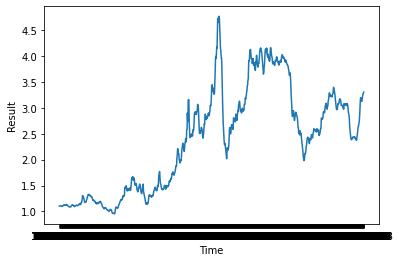

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(1)
plt.plot(graphdf.index, graphdf['Weekly U.S. No 2 Diesel Retail Prices Dollars per Gallon'])
plt.xlabel('Time')
plt.ylabel('Result')
plt.show()